In [18]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

plt.style.use('default')
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.size": 11,
        "font.family": "lmodern",
        "legend.fontsize": "x-small",
        "figure.figsize": (15, 5),
        "axes.labelsize": "x-small",
        "axes.titlesize": "x-small",
        "xtick.labelsize": "xx-small",
        "ytick.labelsize": "xx-small",
    }
)

# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

agent_ids = [1,2]
bag_name = "/home/joshuabird/Desktop/mar25_1"

In [2]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import math
import numpy as np
from scipy.spatial.transform import Rotation
from pathlib import Path
import os
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types
import copy

# Add custom types
interfaces_dir = "../interfaces/msg/"
for file in os.listdir(interfaces_dir):
    msg_text = Path(interfaces_dir + file).read_text()
    register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


In [3]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import numpy as np

traj_ests = {}
with Rosbag2Reader(bag_name) as reader:
    # Read the trajectory and ground truth for each agent
    for agent_id in agent_ids:
        traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose")
        traj_est.timestamps += 0

        traj_ests[agent_id] = traj_est

In [4]:
from evo.core.trajectory import PosePath3DElement

filter_func: PosePath3DElement = lambda element: element["coord_frame"] == "robot1/origin"

# Filter to only the time range where trajectories are merged
for agent_id in agent_ids:
    traj_ests[agent_id].filter(filter_func)

2698 poses, 12.405m path length, 341.670s duration
2415 poses, 33.938m path length, 342.602s duration


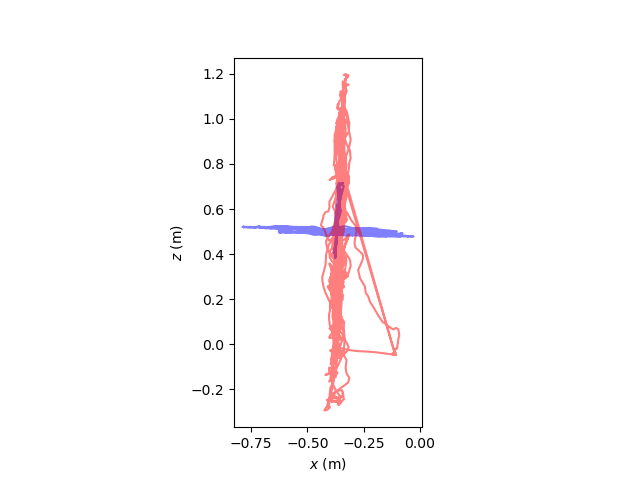

In [5]:
for agent_id in agent_ids:
    print(traj_ests[agent_id])

fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode=PlotMode.xz)
plot.traj(ax, PlotMode.xz, traj_ests[1], color="blue", alpha=0.5)
plot.traj(ax, PlotMode.xz, traj_ests[2], color="red", alpha=0.5)

In [6]:
from geometry_msgs.msg import PoseStamped
from tf2_msgs.msg import TFMessage
from evo.core.trajectory import PosePath3D, PoseTrajectory3D

traj_refs = {}
frame_id_to_agent_id = {
    "robomaster_0": 1,
    "robomaster_1": 2,
}

xyz = {agent_id:[] for agent_id in agent_ids}
quat = {agent_id:[] for agent_id in agent_ids}
stamps = {agent_id:[] for agent_id in agent_ids}

cam_traj_xyz = []
cam_traj_quat = []
cam_traj_stamps = []

with Rosbag2Reader(bag_name) as reader:
    
    topic = "/tf"
    connections = [c for c in reader.connections if c.topic == topic]
    for connection, _, rawdata in reader.messages(connections=connections):
        data = deserialize_cdr(rawdata, connection.msgtype)

        for transform in data.transforms:
            if transform.child_frame_id in frame_id_to_agent_id:
                agent_id = frame_id_to_agent_id[transform.child_frame_id]

                xyz[agent_id].append([transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z])
                quat[agent_id].append([transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z, transform.transform.rotation.w])
                t = transform.header.stamp
                stamps[agent_id].append(t.sec + (t.nanosec * 1e-9))
            elif transform.child_frame_id == "camera_sony":
                cam_traj_xyz.append([transform.transform.translation.x, transform.transform.translation.y, transform.transform.translation.z])
                cam_traj_quat.append([transform.transform.rotation.x, transform.transform.rotation.y, transform.transform.rotation.z, transform.transform.rotation.w])
                t = transform.header.stamp
                cam_traj_stamps.append(t.sec + (t.nanosec * 1e-9))
        
for agent_id in agent_ids:
    traj_refs[agent_id] = PoseTrajectory3D(np.array(xyz[agent_id]), np.array(quat[agent_id]), np.array(stamps[agent_id]))

cam_traj = PoseTrajectory3D(np.array(cam_traj_xyz), np.array(cam_traj_quat), np.array(cam_traj_stamps))

77534 poses, 48.642m path length, 430.869s duration
77534 poses, 137.413m path length, 430.869s duration


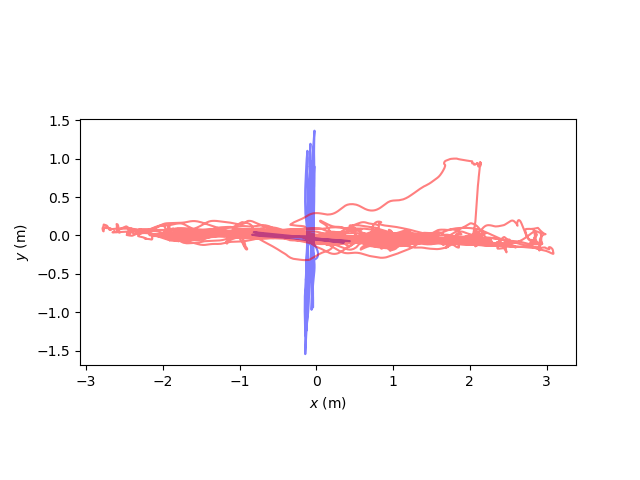

In [7]:
for agent_id in agent_ids:
    print(traj_refs[agent_id])
    
fig = plt.figure()
ax = plot.prepare_axis(fig, plot_mode=PlotMode.xy)
plot.traj(ax, PlotMode.xy, traj_refs[1], color="blue", alpha=0.5)
plot.traj(ax, PlotMode.xy, traj_refs[2], color="red", alpha=0.5)

In [8]:

start_time = 1711402122
end_time = 1711402128

for agent_id in agent_ids:
    traj_refs[agent_id].reduce_to_time_range(start_time, end_time)
    traj_ests[agent_id].reduce_to_time_range(start_time, end_time)

In [9]:
from evo.core import sync
from evo.core.trajectory import align_multiple

max_diff = 0.1

traj_refs_ass = {}
traj_ests_ass = {}

for agent_id in agent_ids:
    traj_refs_ass[agent_id], traj_ests_ass[agent_id] = sync.associate_trajectories(traj_refs[agent_id], traj_ests[agent_id], max_diff)
    
rotation_matrix, translation_vector, scale = align_multiple(list(traj_ests_ass.values()), list(traj_refs_ass.values()), correct_scale=True)

transform = np.eye(4)

transform[:3, :3] = rotation_matrix
transform[:3, 3] = translation_vector.reshape(3)
transform[0, 0] *= scale
transform[1, 1] *= scale
transform[2, 2] *= scale

cam_traj.transform(transform)

print(rotation_matrix, translation_vector, scale)

[[ 4.54445660e-03 -2.70462385e-02 -9.99623854e-01]
 [ 9.99989136e-01 -9.13447822e-04  4.57083186e-03]
 [-1.03672804e-03 -9.99633766e-01  2.70417936e-02]] [1.85027308 1.37459382 0.06917294] 3.8226739499666076


In [10]:
print(np.max(traj_refs_ass[2].speeds))

0.7314874432370354


In [11]:
for agent_id in agent_ids:
    print(traj_refs_ass[agent_id])
    print(traj_ests_ass[agent_id])
    print()

44 poses, 1.698m path length, 5.934s duration
44 poses, 1.740m path length, 5.934s duration

42 poses, 3.525m path length, 5.800s duration
42 poses, 3.484m path length, 5.800s duration



In [12]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure()
    ax = plot.prepare_axis(fig, plot_mode)
    
    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs_ass[agent_id], traj_ests_ass[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results.append(result)

        if show_plot:
            plot.traj(ax, plot_mode, traj_refs_ass[agent_id], style="--", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=result.stats["min"], max_map=result.stats["max"])
            
            plot.traj(ax, plot_mode, cam_traj)
    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [13]:
from rosbags.rosbag2 import Writer as Rosbag2Writer

with Rosbag2Writer(f"{bag_name}_processed") as writer:
    for agent_id in agent_ids:
        file_interface.write_bag_trajectory(writer, traj_ests_ass[agent_id], f"/robot{agent_id}/camera_pose")
        file_interface.write_bag_trajectory(writer, traj_refs[agent_id], f"/robot{agent_id}/ground_truth_pose")
    
    file_interface.write_bag_trajectory(writer, cam_traj, f"/camera_pose")

WriterError: /home/joshuabird/Desktop/mar25_1_processed exists already, not overwriting.

In [14]:
traj_refs[1].timestamps[0]

1711402122.0051267

In [15]:
import pandas as pd

data = []
for agent_id in agent_ids:
    for is_est, traj in enumerate([traj_refs[agent_id], traj_ests_ass[agent_id]]):
        timetamps = traj.timestamps
        positions_xyz = traj.positions_xyz
        orientations_quat_wxyz = traj.orientations_quat_wxyz

        for i in range(len(timetamps)):
            data.append({
                "timestamp": timetamps[i],
                "x": positions_xyz[i][0],
                "y": positions_xyz[i][1],
                "z": positions_xyz[i][2],
                "qw": orientations_quat_wxyz[i][0],
                "qx": orientations_quat_wxyz[i][1],
                "qy": orientations_quat_wxyz[i][2],
                "qz": orientations_quat_wxyz[i][3],
                "topic": f"/robot{agent_id}/camera_pose" if is_est == 1 else f"/robot{agent_id}/ground_truth_pose"
            })


df = pd.DataFrame(data)

df["timestamp"] = df["timestamp"] - df["timestamp"].min() - 0.1
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")

df.to_csv(f"{bag_name}_processed.csv", index=False)

df[(df["topic"] == "/robot1/ground_truth_pose")]["timestamp"]

0      1969-12-31 23:59:59.900000000
1      1969-12-31 23:59:59.905854607
2      1969-12-31 23:59:59.911168719
3      1969-12-31 23:59:59.916948224
4      1969-12-31 23:59:59.922167922
                    ...             
1075   1970-01-01 00:00:05.872429275
1076   1970-01-01 00:00:05.877671623
1077   1970-01-01 00:00:05.883824014
1078   1970-01-01 00:00:05.889067316
1079   1970-01-01 00:00:05.894439840
Name: timestamp, Length: 1080, dtype: datetime64[ns]

/tmp/ipykernel_72917/2107866622.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  est_1_upsampled = est_1.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()
/tmp/ipykernel_72917/2107866622.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  est_2_upsampled = est_2.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()


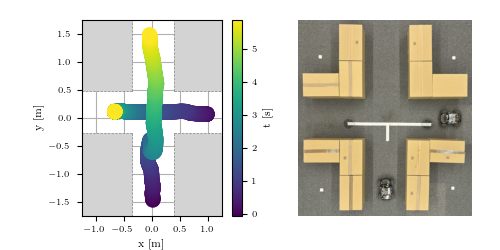

In [34]:
from matplotlib.collections import LineCollection
import matplotlib.patches as patches


# fig = plt.figure(figsize=(5, 5))
# ax1 = fig.add_subplot(111, projection='3d', computed_zorder=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[5.0, 2.5], gridspec_kw={'width_ratios': [1.12, 1]})
fig.tight_layout()

# Intersection example
# start_time = 1711402122
# end_time = 1711402128

# push back and forth example
# start_time = 1711401965
# end_time = 1711401990

# ref_1 = df[(df["topic"] == "/robot1/ground_truth_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
# ref_2 = df[(df["topic"] == "/robot2/ground_truth_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
# ax1.plot(ref_1['y'].values, -ref_1['x'].values, c="orange", alpha=1, zorder=100, linestyle=":", label="Ground Truth")
# ax1.plot(ref_2['y'].values, -ref_2['x'].values, c="orange", alpha=1, zorder=100, linestyle=":")

est_1 = df[(df["topic"] == "/robot1/camera_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
est_2 = df[(df["topic"] == "/robot2/camera_pose")]# & (df["timestamp"] > start_time) & (df["timestamp"] < end_time)]
est_1_upsampled = est_1.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()
est_2_upsampled = est_2.set_index("timestamp").resample("10ms").first().interpolate("linear").reset_index()

ax1.scatter(est_1_upsampled['y'].values, -est_1_upsampled['x'].values, c=est_1_upsampled['timestamp'].astype(int).values/1e9, cmap="viridis", alpha=1, s=100)#, s=2500*0.07*scale)
ax1.scatter(est_2_upsampled['y'].values, -est_2_upsampled['x'].values, c=est_2_upsampled['timestamp'].astype(int).values/1e9, cmap="viridis", alpha=1, s=100)#, s=2500*0.07*scale)

plt.colorbar(ax1.collections[0], ax=ax1, orientation="vertical", label="t [s]", fraction=0.066)

rect_1 = patches.Rectangle((0.4, 0.475), 10, 10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_2 = patches.Rectangle((-0.35, 0.475), -10, 10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_3 = patches.Rectangle((0.4, -0.275), 10, -10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
rect_4 = patches.Rectangle((-0.35, -0.275), -10, -10, linewidth=0.5, edgecolor='grey', facecolor='lightgrey', linestyle="--")
ax1.add_patch(rect_1)
ax1.add_patch(rect_2)
ax1.add_patch(rect_3)
ax1.add_patch(rect_4)

ax1.set_aspect("equal")
ax1.set_xbound(-1.25, 1.25)
ax1.set_ybound(-1.75, 1.75)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.grid()
ax1.set_axisbelow(True)
# ax1.legend(loc='upper right')

ax2.imshow(plt.imread("setup.png"), interpolation=None)
ax2.axis('off')


# Showing plot
plt.show()

fig.savefig("traj_collision_avoidance.pdf", bbox_inches='tight', dpi=300, pad_inches=0)

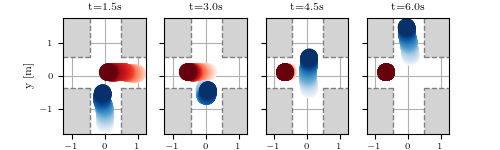

In [25]:
timesteps = 4
timestep = (est_1_upsampled["timestamp"].max() - est_1_upsampled["timestamp"].min()) / timesteps
start_time_datetime = est_1_upsampled["timestamp"].min()

fig, axs = plt.subplots(1, timesteps, figsize=(5, 1.5), sharex=True, sharey=True)

for i in range(timesteps):

    est_1_timestep = est_1_upsampled[(est_1_upsampled["timestamp"] > start_time_datetime + timestep*i) & (est_1_upsampled["timestamp"] < start_time_datetime + timestep*(i+1))]
    est_2_timestep = est_2_upsampled[(est_2_upsampled["timestamp"] > start_time_datetime + timestep*i) & (est_2_upsampled["timestamp"] < start_time_datetime + timestep*(i+1))]

    axs[i].scatter(est_1_timestep["y"].values, -est_1_timestep["x"].values, c=est_1_timestep.index, cmap="Reds", alpha=1, s=500*0.07*scale)
    axs[i].scatter(est_2_timestep["y"].values, -est_2_timestep["x"].values, c=est_2_timestep.index, cmap="Blues", alpha=1, s=500*0.07*scale)

    rect_1 = patches.Rectangle((0.5, 0.575), 10, 10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--")
    rect_2 = patches.Rectangle((-0.45, 0.575), -10, 10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--")
    rect_3 = patches.Rectangle((0.5, -0.375), 10, -10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--")
    rect_4 = patches.Rectangle((-0.45, -0.375), -10, -10, linewidth=1, edgecolor='grey', facecolor='lightgrey', linestyle="--")
    axs[i].add_patch(rect_1)
    axs[i].add_patch(rect_2)
    axs[i].add_patch(rect_3)
    axs[i].add_patch(rect_4)

    axs[i].set_title(f"t={round((timestep*(i+1)).total_seconds()*2)/2}s")
    axs[i].set_aspect("equal")
    axs[i].set_xbound(-1.25, 1.25)
    axs[i].set_ybound(-1.75, 1.75)
    axs[i].set_xlabel("x [m]")
    if i == 0: axs[i].set_ylabel("y [m]")
    axs[i].grid()
    axs[i].set_axisbelow(True)

# Showing plot
plt.show()

fig.savefig("traj_collision_avoidance_timesteps.pdf", bbox_inches='tight', pad_inches=0)

In [224]:
est_1

,timestamp,x,y,z,qw,qx,qy,qz,topic
1080,-0.050695,-0.062782,0.957958,0.076121,0.504532,-0.487705,0.505834,-0.501721,/robot1/camera_pose
1081,0.147554,-0.064397,0.988039,0.078779,0.504496,-0.487627,0.507137,-0.500515,/robot1/camera_pose
1082,0.282241,-0.066553,0.928230,0.080602,0.506735,-0.490252,0.504870,-0.497975,/robot1/camera_pose
1083,0.482257,-0.072459,0.791332,0.094625,0.507449,-0.499737,0.501003,-0.491685,/robot1/camera_pose
1084,0.615574,-0.082040,0.690949,0.099802,0.509896,-0.501104,0.496861,-0.491965,/robot1/camera_pose
1085,0.815244,-0.109831,0.618574,0.136754,0.504676,-0.506639,0.501162,-0.487294,/robot1/camera_pose
1086,0.948448,-0.115891,0.515515,0.148696,0.505987,-0.505551,0.501558,-0.486657,/robot1/camera_pose
1087,1.081832,-0.098194,0.338007,0.113724,0.512137,-0.499656,0.498956,-0.488982,/robot1/camera_pose
1088,1.281348,-0.100234,0.175557,0.111632,0.512566,-0.500787,0.496936,-0.489432,/robot1/camera_pose
1089,1.349129,-0.102856,0.134662,0.114080,0.512606,-0.501874,0.497590,-0.487608,/robot1/camera_pose


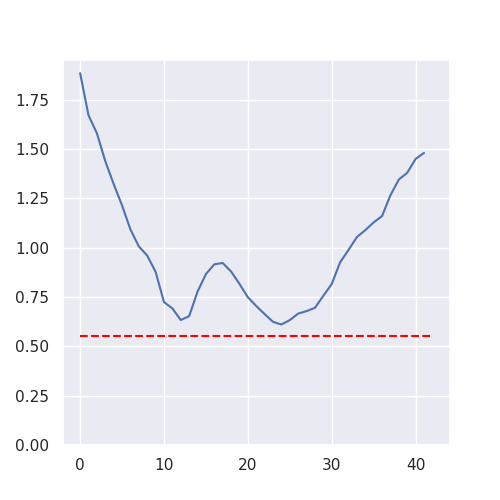

In [ ]:
dist = np.linalg.norm(est_1[['x', 'y']].values[2:] - est_2[['x', 'y']].values, axis=1)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(dist)
ax.hlines(0.07*scale*2, 0, len(dist), colors="red", linestyles="dashed")
ax.set_ybound(0)

plt.show()
